# AI-Driven ML and Data Science Assistant

- **Name**: Muhammad Zafar

- [GitHub](https://github.com/mzafarr)
- [LinkedIn](https://www.linkedin.com/in/zafarr/)

In [ ]:
! pip install pandas numpy langchain scikit-learn optuna openai  langchain_openai kagglehub langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith matplotlib seaborn langchain_nvidia_ai_endpoints umap-learn

### Setting up Environment Variables and importing dataset (NY-House-Dataset.csv) from kaggle

In [13]:
from typing import Dict, Any, List
import logging
from typing import Union, Optional, Tuple, List, Dict, Any

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures, StandardScaler
from scipy import stats
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as UMAP

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

import kagglehub
import os
from google.colab import userdata

# Getting the dataset from Kaggle
DATASET_PATH = kagglehub.dataset_download("nelgiriyewithana/new-york-housing-market") + "/NY-House-Dataset.csv"

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "AutoML-Hackathon"

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(message)s'
)
logger = logging.getLogger(__name__)

def load_dataset() -> pd.DataFrame:
    """Load the dataset from a given path."""
    try:
        df = pd.read_csv(DATASET_PATH)
        logger.info(f"Dataset loaded successfully with shape {df.shape}")
        return df
    except Exception as e:
        logger.error(f"Failed to load dataset: {str(e)}")
        raise

df = load_dataset()
df.sample(3)

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
89,Brokered by Engel & Volkers Brownstone Brooklyn,Condo for sale,215000,1,1.0,625.0,195 Prince St Unit 1LL,"New York, NY 10012","195 Prince St Unit 1LLNew York, NY 10012",New York,New York County,New York,Manhattan,195,"195 Prince St #1r, New York, NY 10012, USA",40.726773,-74.002538
674,Brokered by Corcoran SoHo,Co-op for sale,299000,3,1.0,640.0,410 E 57th St Apt 8B,"New York, NY 10022","410 E 57th St Apt 8BNew York, NY 10022",New York,New York County,New York,Manhattan,410,"410 E 57th St #8b, New York, NY 10022, USA",40.757832,-73.962456
4641,Brokered by Schmidt Realty Inc.,Contingent,669000,3,2.0,2115.0,323 Getz Ave,"Staten Island, NY 10312","323 Getz AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Getz Avenue,"323 Getz Ave, Staten Island, NY 10312, USA",40.551553,-74.164629


## Tools and Utils

In [19]:
def train_and_evaluate_classification_models(
    target_column: str,
    models: Dict[str, Any] = None,
    cv_folds: int = 5
) -> Dict[str, Dict[str, float]]:
    """
    Train and evaluate multiple classification models using cross-validation.
    Args:
        target_column: Name of the target column in the global DataFrame.
        models: Dictionary of model names and model instances (in case you don't provide, then this function will use these: {
                "Linear Regression": LinearRegression(max_iter=1000),
                "Random Forest": RandomForestClassifier(),
                "Support Vector Machine": SVC(),
                "Decision Tree": DecisionTreeClassifier(),
            }).
        cv_folds: Number of cross-validation folds.
    Returns:
        Dictionary with model performance metrics.
    """
    try:
        logger.info("Starting classification model training and evaluation")
        if models is None:
            models = {
                "Logistic Regression": LogisticRegression(max_iter=1000),
                "Random Forest": RandomForestClassifier(),
                "Support Vector Machine": SVC(),
                "Decision Tree": DecisionTreeClassifier(),
            }
        X = df.drop(columns=[target_column])
        y = df[target_column]
        results = {}
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        for model_name, model in models.items():
            logger.info(f"Evaluating model: {model_name}")
            pipeline = Pipeline([
                ('model', model)
            ])
            cv_results = cross_val_score(
                pipeline, X, y, cv=cv, scoring='accuracy'
            )
            results[model_name] = {
                "Accuracy Mean": cv_results.mean(),
                "Accuracy Std": cv_results.std()
            }
        logger.info("Classification models evaluated successfully")
        return results
    except Exception as e:
        logger.error(f"Error in classification model evaluation: {str(e)}")
        raise

def train_and_evaluate_regression_models(
    target_column: str,
    models: Dict[str, Any] = None,
    cv_folds: int = 5
) -> Dict[str, Dict[str, float]]:
    """
    Train and evaluate multiple regression models using cross-validation.
    Args:
        target_column: Name of the target column in the global DataFrame.
        models: Dictionary of model names and model instances (in case you don't provide, then this function will use these: {
                "Linear Regression": LinearRegression(),
                "Random Forest": RandomForestRegressor(),
                "Support Vector Machine": SVR(),
                "Decision Tree": DecisionTreeRegressor(),
            }).
        cv_folds: Number of cross-validation folds.
    Returns:
        Dictionary with model performance metrics.
    """
    try:
        logger.info("Starting regression model training and evaluation")
        if models is None:
            models = {
                "Linear Regression": LinearRegression(),
                "Random Forest": RandomForestRegressor(),
                "Support Vector Machine": SVR(),
                "Decision Tree": DecisionTreeRegressor(),
            }
        X = df.drop(columns=[target_column])
        y = df[target_column]
        results = {}
        cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        for model_name, model in models.items():
            logger.info(f"Evaluating model: {model_name}")
            pipeline = Pipeline([
                ('model', model)
            ])
            cv_results = cross_val_score(
                pipeline, X, y, cv=cv, scoring='neg_mean_squared_error'
            )
            mse_scores = -cv_results
            results[model_name] = {
                "MSE Mean": mse_scores.mean(),
                "MSE Std": mse_scores.std()
            }
        logger.info("Regression models evaluated successfully")
        return results
    except Exception as e:
        logger.error(f"Error in regression model evaluation: {str(e)}")
        raise

def detect_and_handle_outliers(
    column_name: str,
    method: str = "zscore",
    threshold: float = 3.0
) -> Dict[str, Any]:
    """
    Detect and handle outliers in a specified column.
    Args:
        column_name: Name of the column to process.
        method: Outlier detection method, either 'zscore' or 'iqr'.
        threshold: Threshold for outlier detection.
    Returns:
        Dictionary with outlier analysis results.
    """
    try:
        logger.info(f"Detecting outliers in {column_name} using {method}")
        if column_name not in df.columns:
            return {"error": f"Column '{column_name}' not found in dataset"}
        if not pd.api.types.is_numeric_dtype(df[column_name]):
            return {"error": "Column must be numeric"}
        column_data = df[column_name]
        outlier_mask = None
        if method == "zscore":
            z_scores = stats.zscore(column_data, nan_policy="omit")
            outlier_mask = np.abs(z_scores) > threshold
        elif method == "iqr":
            Q1 = column_data.quantile(0.25)
            Q3 = column_data.quantile(0.75)
            IQR = Q3 - Q1
            outlier_mask = (column_data < (Q1 - threshold * IQR)
                            ) | (column_data > (Q3 + threshold * IQR))
        outliers_count = outlier_mask.sum()
        return {
            "total_outliers": int(outliers_count),
            "outlier_percentage": float((outliers_count / len(column_data)) * 100),
            "original_stats": {
                "mean": float(column_data.mean()),
                "std": float(column_data.std())
            }
        }
    except Exception as e:
        logger.error(f"Error detecting outliers: {str(e)}")
        raise

def analyze_column_distribution(
    column_name: str,
    plot: bool = False
) -> Dict[str, Any]:
    """
    Analyze the distribution of a column.
    Args:
        column_name: Name of the column to analyze.
        plot: Whether to generate distribution plots.
    Returns:
        Dictionary with column distribution statistics.
    """
    try:
        logger.info(f"Analyzing distribution for column: {column_name}")
        if column_name not in df.columns:
            return {"error": f"Column '{column_name}' not found in dataset"}

        stats_dict = {
            "skewness": float(df[column_name].skew()),
            "kurtosis": float(df[column_name].kurtosis()),
            "normality_test": None
        }

        if pd.api.types.is_numeric_dtype(df[column_name]):
            if len(df[column_name].dropna()) >= 3:
                _, p_value = stats.shapiro(df[column_name].dropna())
                stats_dict["normality_test"] = {
                    "test": "shapiro",
                    "p_value": float(p_value),
                    "is_normal": p_value > 0.05
                }

        if plot:
            plt.figure(figsize=(10, 6))

            if pd.api.types.is_numeric_dtype(df[column_name]):
                # Check if data is highly skewed
                if df[column_name].skew() > 5:  # Adjust threshold as needed
                    # Use log scale for highly skewed data
                    sns.histplot(
                        data=df,
                        x=column_name,
                        kde=True,
                        bins=50,
                        log_scale=True,  # Add log scale
                        color='skyblue',
                        edgecolor='white'
                    )
                    plt.xscale('log')  # Set x-axis to log scale
                else:
                    # Regular plot for less skewed data
                    sns.histplot(
                        data=df,
                        x=column_name,
                        kde=True,
                        bins=30,
                        color='skyblue',
                        edgecolor='white'
                    )
            else:
                sns.countplot(data=df, x=column_name)

            plt.title(f"Distribution of {column_name}")
            plt.xticks(rotation=45)

            # Add grid for better readability
            plt.grid(True, alpha=0.3)

            # Format x-axis for large numbers
            if pd.api.types.is_numeric_dtype(df[column_name]):
                plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

            plt.tight_layout()
            plt.show()

        return stats_dict

    except Exception as e:
        logger.error(f"Error analyzing column distribution: {str(e)}")
        raise

def auto_detect_data_types() -> Dict[str, List[str]]:
    """
    Automatically detect and categorize columns by data types.
    Returns:
        Dictionary categorizing dataset columns by type.
    """
    try:
        logger.info("Auto-detecting data types")
        types = {"numeric": [], "categorical": [],
                 "datetime": [], "text": [], "binary": [], "other": []}
        for col in df.columns:
            dtype = df[col].dtype
            if pd.api.types.is_numeric_dtype(dtype):
                if df[col].nunique() <= 2:
                    types["binary"].append(col)
                else:
                    types["numeric"].append(col)

            elif pd.api.types.is_datetime64_any_dtype(dtype):
                types["datetime"].append(col)
            elif pd.api.types.is_string_dtype(dtype):
                types["categorical" if df[col].nunique() <=
                      50 else "text"].append(col)
            else:
                types["other"].append(col)
        return types
    except Exception as e:
        logger.error(f"Error detecting data types: {str(e)}")
        raise

def check_missing_values(data: str = "all") -> Dict[str, int]:
    """Check for missing values in the dataset.
    Args:
        data: Column name or "all" for entire dataset
    """
    try:
        logger.info(f"Checking missing values for: {data}")
        if data == "all":
            missing_counts = df.isna().sum().to_dict()
        else:
            missing_counts = {data: df[data].isna().sum()}
        logger.info(f"Missing value counts: {missing_counts}")
        return missing_counts
    except Exception as e:
        logger.error(f"Error in check_missing_values: {str(e)}")
        raise

def get_dataset_info() -> Dict[str, Any]:
    """
    Retrieve basic information about the dataset.
    Returns:
        Dictionary with dataset structure and statistics.
    """
    try:
        logger.info("Retrieving dataset information")
        info = {
            "shape": df.shape,
            "columns": df.columns.tolist(),
            "dtypes": {col: str(dtype) for col, dtype in df.dtypes.items()},
            "description": df.describe(include="all").to_dict()
        }
        logger.info("Dataset information retrieved successfully")
        return info
    except Exception as e:
        logger.error(f"Error retrieving dataset info: {str(e)}")
        raise

def get_column_stats(column_name: str) -> Dict[str, Any]:
    """
    Retrieve detailed statistical information about a specific column.
    Args:
        column_name: Name of the column to analyze.
    Returns:
        Dictionary with column statistics.
    """
    try:
        logger.info(f"Retrieving statistics for column: {column_name}")
        if column_name not in df.columns:
            return {"error": f"Column '{column_name}' not found in dataset"}
        column_data = df[column_name]
        stats = {
            "dtype": str(column_data.dtype),
            "unique_values": int(column_data.nunique()),
            "missing_values": int(column_data.isna().sum())
        }
        if pd.api.types.is_numeric_dtype(column_data):
            stats.update({
                "mean": float(column_data.mean()),
                "median": float(column_data.median()),
                "std": float(column_data.std()),
                "min": float(column_data.min()),
                "max": float(column_data.max())
            })
        logger.info(f"Statistics retrieved for column: {column_name}")
        return stats
    except Exception as e:
        logger.error(f"Error retrieving column statistics: {str(e)}")
        raise

def handle_missing_values(
    strategy: str = 'median',
    columns: List[str] = None
) -> None:
    """
    Handle missing values in the dataset using the specified strategy.
    Args:
        strategy: Imputation strategy - 'mean', 'median', 'mode', or 'drop'.
        columns: List of columns to apply the imputation. If None, apply to all columns.
    """
    try:
        logger.info(f"Handling missing values using strategy: {strategy}")
        if columns is None:
            columns = df.columns.tolist()
        for column in columns:
            if df[column].isna().sum() > 0:
                if strategy == 'mean' and pd.api.types.is_numeric_dtype(df[column]):
                    mean_value = df[column].mean()
                    df[column].fillna(mean_value, inplace=True)
                elif strategy == 'median' and pd.api.types.is_numeric_dtype(df[column]):
                    median_value = df[column].median()
                    df[column].fillna(median_value, inplace=True)
                elif strategy == 'mode':
                    mode_value = df[column].mode()[0]
                    df[column].fillna(mode_value, inplace=True)
                elif strategy == 'drop':
                    df.dropna(subset=[column], inplace=True)
                else:
                    logger.warning(
                        f"Strategy '{strategy}' is not applicable for column '{column}' with dtype '{df[column].dtype}'")

        logger.info("Missing values handled successfully.")
    except Exception as e:
        logger.error(f"Error handling missing values: {str(e)}")
        raise

def encode_categorical_variables(
    encoding_type: str = 'onehot',
    columns: List[str] = None
) -> None:
    """
    Encode categorical variables into numerical values.
    Args:
        encoding_type: Encoding method - 'onehot' or 'label'.
        columns: List of columns to encode. If None, auto-detect categorical columns.
    """
    try:
        logger.info(
            f"Encoding categorical variables using {encoding_type} encoding")
        if columns is None:
            data_types = auto_detect_data_types()
            columns = data_types.get('categorical', [])
            if not columns:
                logger.info("No categorical columns to encode")
                return
        for column in columns:
            if encoding_type == 'onehot':
                df_encoded = pd.get_dummies(df[column], prefix=column)
                df.drop(column, axis=1, inplace=True)
                df[df_encoded.columns] = df_encoded
            elif encoding_type == 'label':
                le = LabelEncoder()
                df[column] = le.fit_transform(df[column].astype(str))
            else:
                logger.warning(f"Unknown encoding type: {encoding_type}")
        logger.info("Categorical variables encoded successfully.")
    except Exception as e:
        logger.error(f"Error encoding categorical variables: {str(e)}")
        raise

def scale_features(
    scaling_method: str = 'standard',
    columns: List[str] = None
) -> None:
    """
    Scale numerical features using the specified scaling method.
    Args:
        scaling_method: Scaling method - 'standard' or 'minmax'.
        columns: List of columns to scale. If None, apply to all numeric columns.
    """
    try:
        logger.info(f"Scaling features using {scaling_method} scaling")
        if columns is None:
            data_types = auto_detect_data_types()
            columns = data_types.get('numeric', [])
        if not columns:
            logger.info("No numerical columns to scale")
            return
        if scaling_method == 'standard':
            scaler = StandardScaler()
        elif scaling_method == 'minmax':
            scaler = MinMaxScaler()
        else:
            logger.warning(f"Unknown scaling method: {scaling_method}")
            return
        df[columns] = scaler.fit_transform(df[columns])
        logger.info("Features scaled successfully.")
    except Exception as e:
        logger.error(f"Error scaling features: {str(e)}")
        raise

def feature_selection(
    method: str = 'variance',
    threshold: float = 0.0
) -> None:
    """
    Perform feature selection to reduce dimensionality.
    Args:
        method: Feature selection method - 'variance' or 'correlation'.
        threshold: Threshold value for the feature selection method.
    """
    try:
        logger.info(f"Performing feature selection using {method} method")
        if method == 'variance':
            selector = VarianceThreshold(threshold)
            selector.fit(df)
            df_reduced = df[df.columns[selector.get_support(indices=True)]]
            df.drop(columns=df.columns.difference(
                df_reduced.columns), inplace=True)
        elif method == 'correlation':
            corr_matrix = df.corr().abs()
            upper = corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            to_drop = [column for column in upper.columns if any(
                upper[column] > threshold)]
            df.drop(columns=to_drop, inplace=True)
        else:
            logger.warning(f"Unknown feature selection method: {method}")
        logger.info("Feature selection completed successfully.")
    except Exception as e:
        logger.error(f"Error during feature selection: {str(e)}")
        raise

def create_polynomial_features(
    degree: int = 2,
    interaction_only: bool = False,
    columns: List[str] = None
) -> None:
    """
    Generate polynomial and interaction features from existing numerical features.
    Args:
        degree: Degree of the polynomial features.
        interaction_only: If True, only interaction features are produced.
        columns: List of columns to generate features for. If None, use all numeric columns.
    """
    try:
        logger.info(f"Creating polynomial features with degree {degree}")
        if columns is None:
            data_types = auto_detect_data_types()
            columns = data_types.get('numeric', [])
        poly = PolynomialFeatures(
            degree=degree, interaction_only=interaction_only, include_bias=False)
        poly_features = poly.fit_transform(df[columns])
        feature_names = poly.get_feature_names_out(columns)
        df_poly = pd.DataFrame(
            poly_features, columns=feature_names, index=df.index)
        df.drop(columns=columns, inplace=True)
        df[df_poly.columns] = df_poly
        logger.info("Polynomial features created successfully.")
    except Exception as e:
        logger.error(f"Error creating polynomial features: {str(e)}")
        raise

def save_dataframe_to_csv(file_name: str = "output.csv") -> None:
    """
    Save the given DataFrame to a CSV file in the current directory.
    Args:
        df: The DataFrame to save.
        file_name: The name of the file to save the DataFrame as.
    """
    try:
        df.to_csv(file_name, index=False)
        print(f"DataFrame saved successfully as {file_name}")
    except Exception as e:
        print(f"Error saving DataFrame to CSV: {str(e)}")

def operations_on_dataset(
    task: str,
    column_1: Optional[str] = None,
    column_2: Optional[str] = None,
    operation: Optional[str] = None,
    group_by: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Perform data analysis or transformation based on the task.

    Args:
        task: The type of task to perform (e.g., "calculate", "filter", "summarize", "group").
        column_1: Primary column for operations.
        column_2: Secondary column for operations (if needed).
        operation: Specific operation to perform (e.g., "add", "subtract", "divide", "mean").
        group_by: Column name to group data by (for group operations).

    Returns:
        A dictionary containing the results or the modified df.
    """
    try:
        # Validate input
        if df.empty:
            return {"error": "The df is empty."}
        if task not in ["calculate", "filter", "summarize", "group", "transform", "visualize"]:
            return {"error": f"Task '{task}' is not supported."}

        # Task 1: Calculate new metrics (e.g., arithmetic operations)
        if task == "calculate":
            if not column_1 or not operation:
                return {"error": "For 'calculate', 'column_1' and 'operation' must be specified."}
            if column_1 not in df.columns:
                return {"error": f"Column '{column_1}' not found in the df."}

            # Handle arithmetic operations
            if operation in ["add", "subtract", "multiply", "divide"]:
                if not column_2 or column_2 not in df.columns:
                    return {"error": f"Column '{column_2}' must be provided for the '{operation}' operation."}

                # Perform the specified operation
                if operation == "add":
                    df[f"{column_1}_plus_{column_2}"] = df[column_1] + df[column_2]
                elif operation == "subtract":
                    df[f"{column_1}_minus_{column_2}"] = df[column_1] - df[column_2]
                elif operation == "multiply":
                    df[f"{column_1}_times_{column_2}"] = df[column_1] * df[column_2]
                elif operation == "divide":
                    df[f"{column_1}_per_{column_2}"] = df[column_1] / df[column_2].replace(0, np.nan)

                return {
                    "result": f"New column created using '{operation}' between '{column_1}' and '{column_2}'.",
                    "data_preview": df.head().to_dict()
                }

            # Other operations (mean, median, std, etc.)
            elif operation in ["mean", "median", "std", "sum", "min", "max"]:
                result = getattr(df[column_1], operation)()
                return {"result": f"{operation.capitalize()} of '{column_1}' is {result:.2f}"}

            else:
                return {"error": f"Operation '{operation}' is not recognized."}

        # Task 2: Filter data
        elif task == "filter":
            filter_column = kwargs.get("filter_column")
            filter_value = kwargs.get("filter_value")
            if not filter_column or filter_column not in df.columns:
                return {"error": f"Invalid filter column '{filter_column}' specified."}
            filtered_data = df[df[filter_column] == filter_value]
            return {"result": f"Filtered {len(filtered_data)} rows.", "data_preview": filtered_data.head().to_dict()}

        # Task 3: Summarize data
        elif task == "describe":
            summary_stats = df.describe(include="all").to_dict()
            return {"result": "Summary statistics generated.", "describe": summary_stats}

        # Task 4: Group data
        elif task == "group":
            if not group_by or group_by not in df.columns:
                return {"error": f"Group-by column '{group_by}' not found in the df."}
            if not column_1 or operation not in ["mean", "sum", "count", "min", "max"]:
                return {"error": "Invalid column or operation specified for grouping."}

            grouped_data = df.groupby(group_by)[column_1].agg(operation).reset_index()
            return {
                "result": f"Data grouped by '{group_by}' with '{operation}' operation on '{column_1}'.",
                "grouped_data": grouped_data.to_dict()
            }

        # Task 5: Transform data
        elif task == "transform":
            transform_function = kwargs.get("transform_function")
            if not transform_function or not callable(transform_function):
                return {"error": "Invalid or missing transform function."}
            df[f"{column_1}_transformed"] = df[column_1].apply(transform_function)
            return {"result": f"Transformed column '{column_1}' added.", "data_preview": df.head().to_dict()}

        # Task 6: Visualize data (e.g., histograms)
        elif task == "visualize":
            import matplotlib.pyplot as plt
            import seaborn as sns
            if not column_1:
                return {"error": "For 'visualize', 'column_1' must be specified."}
            plt.figure(figsize=(8, 5))
            sns.histplot(data=df, x=column_1, kde=True)
            plt.title(f"Distribution of {column_1}")
            plt.show()
            return {"result": f"Histogram for '{column_1}' displayed."}

        else:
            return {"error": "Invalid task specified."}

    except Exception as e:
        return {"error": str(e)}

def dimensionality_reduction(
    method: str = "pca",
    n_components: int = 2,
    visualize: bool = True
) -> Dict[str, Any]:
    """
    Perform dimensionality reduction on the dataset.

    Args:
        method: The dimensionality reduction method ('pca', 'tsne', 'umap').
        n_components: Number of dimensions to reduce to (default: 2).
        visualize: Whether to plot the reduced dimensions if n_components <= 3.

    Returns:
        Dictionary with reduced data and explained variance if applicable.
    """
    try:
        logger.info(f"Performing dimensionality reduction using {method.upper()} with {n_components} components.")
        numeric_data = df.select_dtypes(include=np.number).dropna()

        if numeric_data.empty:
            return {"error": "No numeric data available for dimensionality reduction."}

        if method == "pca":
            model = PCA(n_components=n_components)
            reduced_data = model.fit_transform(numeric_data)
            explained_variance = model.explained_variance_ratio_.sum()

        elif method == "tsne":
            model = TSNE(n_components=n_components, random_state=42)
            reduced_data = model.fit_transform(numeric_data)
            explained_variance = None

        elif method == "umap":
            model = UMAP(n_components=n_components, random_state=42)
            reduced_data = model.fit_transform(numeric_data)
            explained_variance = None

        else:
            return {"error": f"Invalid method: {method}. Choose from 'pca', 'tsne', 'umap'."}

        result = {"reduced_data": reduced_data, "explained_variance": explained_variance}

        if visualize and n_components <= 3:
            import matplotlib.pyplot as plt
            from mpl_toolkits.mplot3d import Axes3D

            fig = plt.figure(figsize=(10, 8))
            if n_components == 2:
                plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.5)
                plt.title(f"{method.upper()} Visualization (2D)")
                plt.xlabel("Component 1")
                plt.ylabel("Component 2")
            elif n_components == 3:
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c='blue', alpha=0.5)
                ax.set_title(f"{method.upper()} Visualization (3D)")
                ax.set_xlabel("Component 1")
                ax.set_ylabel("Component 2")
                ax.set_zlabel("Component 3")
            plt.tight_layout()
            plt.show()

        return result

    except Exception as e:
        logger.error(f"Error in dimensionality reduction: {str(e)}")
        raise

## LangGraph setup

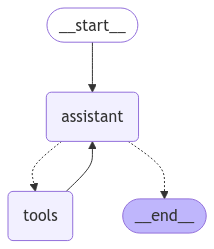

In [20]:
# Set up tools and LLM
tools = [check_missing_values, get_dataset_info, get_column_stats, detect_and_handle_outliers, analyze_column_distribution, auto_detect_data_types, train_and_evaluate_classification_models, train_and_evaluate_regression_models, operations_on_dataset, save_dataframe_to_csv]

logger.info("Initializing ChatOpenAI and binding tools")
llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools)

sys_msg = SystemMessage(content="""You are an absolute expert at AI/ML, Data science, data analysis, with 20+ years of experience, equipped with dozens of data analysis, ai/ml tools for data cleaning, type recognition, applying ML models, visualization, and more. You are expected to tackle a variety of data-focused tasks by selecting optimal tools to provide a solution efficiently, you can use as many tools as you want, but use only when important for the task at hand, if user task involves a lot of steps, do it step by step and when all tasks done you can save the result using save_dataframe_to_csv (even if user doesn't ask you to).

- all provided tools have access to users dataset.
- Select the specific tool to use based on the objective.
- Validate the data quality, clean or transform if needed.
- Choose the appropriate approaches to analyze, transform, or visualize data.
- When applying machine learning models, specify the type of task (e.g., classification, regression).
- Focus more on delivering the final solution rather than an in-depth explanation of every step.

# Steps
1. **Understand the Task**: Grasp the user's question or desired objective, for complex/lengthy tasks break the problem down into steps and solve it step-wise.
2. **Data Preprocessing**:
   - make sure to do preprocessing only when user task requires it or user specifies to do it.
   - Identify data types, column names, and missing values.
   - Clean data and perform transformations if required.
3. **Tool Selection and Execution**:
   - Select the most suitable tool to meet the objective (e.g., statistical analysis vs. machine learning).
   - Apply these tools to complete the objective.

# Output Format
- Provide the final answer or insight to the given task.
- Use markdown to structure important results clearly.
- Avoid step-by-step detailed reasoning; focus on final action, tools used, and outcomes.

# Examples
**Input**: "Analyze the sales trends over the last six months and suggest a forecasting model to predict future sales growth."
**Output**:
- Sales data shows a consistent monthly increase of ~8%.
- Selected ARIMA for future trend forecasting due to seasonal pattern observations.
- Expected growth rate: approximately 10% for the next three months.

# Notes
- Ensure reproducibility by noting key tool parameters when appropriate.
- Focus on delivering a concise final answer rather than providing excessive detailed reasoning.
- Highlight key insights and findings without explaining each processing step.
""")

# Assistant node
def assistant(state: MessagesState):
    """
    Assistant node for processing messages.
    Args:
        state: State of the conversation messages.
    Returns:
        Updated state with assistant response.
    """
    try:
        logger.info("Assistant node processing message")
        response = llm_with_tools.invoke([sys_msg] + state["messages"])
        logger.info(
            f"Assistant generated response: {response.content[:100]}...")
        return {"messages": [response]}
    except Exception as e:
        logger.error(f"Error in assistant node: {str(e)}")
        raise

# Build graph
logger.info("Building graph")
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools", "assistant")

# Add memory
logger.info("Adding memory to graph")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

def run_automl_agent(input_message: str, thread_id: str):
    logger.info(f"Running AutoML agent with thread_id: {thread_id}")
    config = {"configurable": {"thread_id": thread_id}, "recursion_limit": 50}
    messages = [HumanMessage(content=input_message)]
    try:
        response = graph.invoke({"messages": messages}, config)
        logger.info("Successfully processed request")
        return response
    except Exception as e:
        logger.error(f"Error running AutoML agent: {str(e)}")
        raise

## Run Test Questions

===================== Question =============================
 Calculate the price per square foot for each property.
DataFrame saved successfully as properties_with_price_per_sqft.csv
===================== Result =============================





- Calculated the price per square foot for each property successfully.
- The results have been saved in a CSV file named **properties_with_price_per_sqft.csv**.



==================== Question =========================
 visualise price of houses for me.


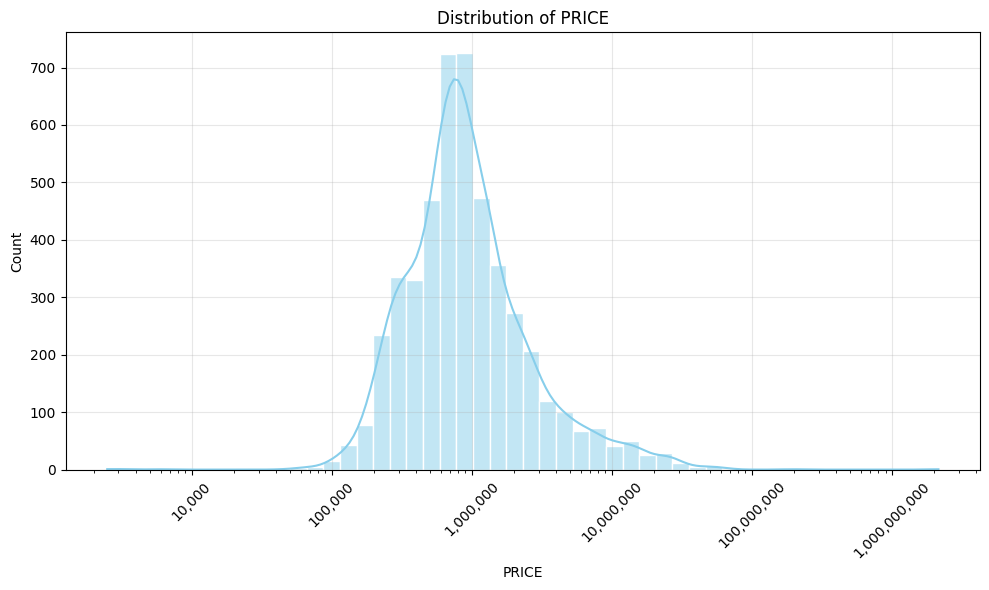

===================== Result =============================




- The visualization for the price of houses has been generated.
- Key statistics indicate a **highly skewed distribution** with a skewness of **66.8** and a kurtosis of **4566.85**.
- A normality test (Shapiro-Wilk) resulted in a **p-value < 0.05**, confirming that the price distribution is not normal. 

If you need further analysis or specific insights, please let me know!

The visualization for the price of houses has already been generated, showing:

- **Skewness**: 66.8 (indicating a highly skewed distribution)
- **Kurtosis**: 4566.85 (indicating a very peaked distribution)
- **Normality Test (Shapiro-Wilk)**: p-value < 0.05 (confirming the distribution is not normal)

If you would like me to provide any specific visualizations or further analysis, please let me know!


In [22]:
question = "Calculate the price per square foot for each property."
print("===================== Question =============================\n", question)
result = run_automl_agent(question, "2")
print("===================== Result =============================\n")
for msg in result["messages"]:
    if isinstance(msg, AIMessage):
        print(msg.content)

question = "visualise price of houses for me."
print("\n\n\n==================== Question =========================\n", question)
result = run_automl_agent(question, "3")
print("===================== Result =============================\n")
for msg in result["messages"]:
    if isinstance(msg, AIMessage):
        print(msg.content)


## Chat With it

In [ ]:
def chat_interface():
    """
    Simple command-line interface for interacting with the AutoML assistant.
    """
    thread_id = "10"

    print("Welcome to the AutoML Assistant! Type 'exit' to end the conversation.")
    print("You can ask questions about the NY House Dataset.")
    print("\nExample questions:")
    print("1. What's the overall structure of the dataset?")
    print("2. Are there any missing values?")
    print("3. Can you analyze the 'price' column?")

    while True:
        user_input = input("\nUser: ")
        if user_input.lower() == "exit":
            print("\nThank you for using the AutoML Assistant. Goodbye!")
        try:
            result = run_automl_agent(user_input, thread_id)
            print("\nAssistant:", end=" ")
            for msg in result["messages"]:
                if isinstance(msg, AIMessage):
                    print(msg.content)

        except Exception as e:
            logger.error(f"Error in chat interface: {str(e)}")
            print(f"\nAn error occurred: {str(e)}")

if __name__ == "__main__":
    chat_interface()

Welcome to the AutoML Assistant! Type 'exit' to end the conversation.
You can ask questions about the NY House Dataset.

Example questions:
1. What's the overall structure of the dataset?
2. Are there any missing values?
3. Can you analyze the 'price' column?

User: What's the overall structure of the dataset?

Assistant: 
The dataset has the following structure:

- **Total Records**: 4,801
- **Total Columns**: 18

### Column Names and Data Types:
1. **BROKERTITLE**: object
2. **TYPE**: object
3. **PRICE**: int64
4. **BEDS**: int64
5. **BATH**: float64
6. **PROPERTYSQFT**: float64
7. **ADDRESS**: object
8. **STATE**: object
9. **MAIN_ADDRESS**: object
10. **ADMINISTRATIVE_AREA_LEVEL_2**: object
11. **LOCALITY**: object
12. **SUBLOCALITY**: object
13. **STREET_NAME**: object
14. **LONG_NAME**: object
15. **FORMATTED_ADDRESS**: object
16. **LATITUDE**: float64
17. **LONGITUDE**: float64
18. **PRICE_per_PROPERTYSQFT**: float64

### Key Summary Statistics:
- **PRICE**: Mean = 2,356,940.17,